In [10]:
%run efx_charity

loaded efx algorithm


number of players: 3
number of item types: 2
number of items of each type: 2,3
valuation for player 0: 4,1
valuation for player 1: 4,1
valuation for player 2: 5,2


APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
APPLIED U0
DONE
player 0 assignments: [1. 0.]
player 1 assignments: [1. 0.]
player 2 assignments: [0. 3.]


(3,
 2,
 array([[1., 0.],
        [1., 0.],
        [0., 3.]]),
 array([2., 3.]),
 array([[4., 1.],
        [4., 1.],
        [5., 2.]]))

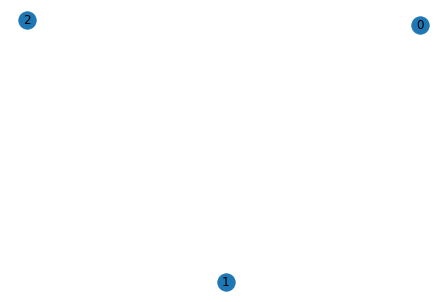

In [11]:
run_and_check(draw=True)